FACET is composed of the following key components:

- **Model Inspection**

    FACET introduces a new algorithm to quantify dependencies and interactions between features in ML models. This new tool for human-explainable AI adds a new, global perspective to the observation-level explanations provided by the popular [SHAP](https://shap.readthedocs.io/en/latest/) approach. To learn more about FACET's model inspection capabilities, see the getting started example below.


- **Model Simulation**

    FACET's model simulation algorithms use ML models for *virtual experiments* to help identify scenarios that optimise predicted  outcomes. To quantify the uncertainty in simulations, FACET utilises a range of bootstrapping algorithms including stationary and stratified bootstraps. For an example of FACET’s bootstrap simulations, see the getting started example below.    
    
    
- **Enhanced Machine Learning Workflow**  

    FACET offers an efficient and transparent machine learning workflow, enhancing [scikit-learn]( https://scikit-learn.org/stable/index.html)'s tried and tested pipelining paradigm with new capabilities for model selection, inspection, and simulation. FACET also introduces [sklearndf](https://github.com/BCG-Gamma/sklearndf), an augmented version of *scikit-learn* with enhanced support for *pandas* dataframes that ensures end-to-end traceability of features.       

In [2]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx

import warnings

warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt

def _configure_matplotlib():
    # set global options for matplotlib

    import matplotlib

    matplotlib.rcParams["figure.figsize"] = (16.0, 8.0)
    matplotlib.rcParams["figure.dpi"] = 72


_configure_matplotlib()

del _configure_matplotlib

# Pipelining & Model Ranking

In [3]:
# standard imports
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import RepeatedKFold

# some helpful imports from sklearndf
from sklearndf.pipeline import RegressorPipelineDF
from sklearndf.regression import RandomForestRegressorDF

# relevant FACET imports
from facet.data import Sample
from facet.selection import LearnerRanker, LearnerGrid

# load Boston housing dataset
boston = load_boston()
boston_df = pd.DataFrame(data=boston.data, columns=boston.feature_names).assign(
    MEDIAN_HOUSE_PRICE=boston.target
)

# create FACET sample object
boston_sample = Sample(observations=boston_df, target_name="MEDIAN_HOUSE_PRICE")

# create pipeline for random forest regressor
rforest_reg = RegressorPipelineDF(regressor=RandomForestRegressorDF(random_state=42))

# define grid of models which are "competing" against each other
rnd_forest_grid = [
    LearnerGrid(
        pipeline=rforest_reg, learner_parameters={"min_samples_leaf": [8, 11, 15]}
    )
]

# create repeated k-fold CV iterator
rkf_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# rank your models by performance (default is mean CV score - 2*SD)
ranker = LearnerRanker(grids=rnd_forest_grid, cv=rkf_cv, n_jobs=-3).fit(sample=boston_sample)

# get summary report
ranker.summary_report()

ranking_score  r2_score                          regressor  \
                        mean       std                     type   
rank                                                              
0         0.721234  0.813158  0.045962  RandomForestRegressorDF   
1         0.706528  0.801775  0.047623  RandomForestRegressorDF   
2         0.691872  0.788968  0.048548  RandomForestRegressorDF   

                       
     min_samples_leaf  
rank                   
0                   8  
1                  11  
2                  15

# Model inspection

FACET implements several model inspection methods for
[scikit-learn](<https://scikit-learn.org/stable/index.html>) estimators.
Fundamentally, FACET enables post-hoc model inspection by breaking down the interaction
effects of the variables that your model used for training:

- **Redundancy**
  represents how much information is shared between two features
  contributions to the model predictions. For example, temperature and pressure in a pressure cooker are
  redundant features for predicting cooking time since pressure will rise relative to
  the temperature, and vice versa. Therefore, knowing just one of either temperature or
  pressure will likely enable the same predictive accuracy. Redundancy is expressed as
  a percentage ranging from 0% (full uniqueness) to 100% (full redundancy).

- **Synergy**
  represents how much the combined information of two features contributes to
  the model predictions. For example, given features X and Y as
  coordinates on a chess board, the colour of a square can only be predicted when
  considering X and Y in combination. Synergy is expressed as a
  percentage ranging from 0% (full autonomy) to 100% (full synergy)

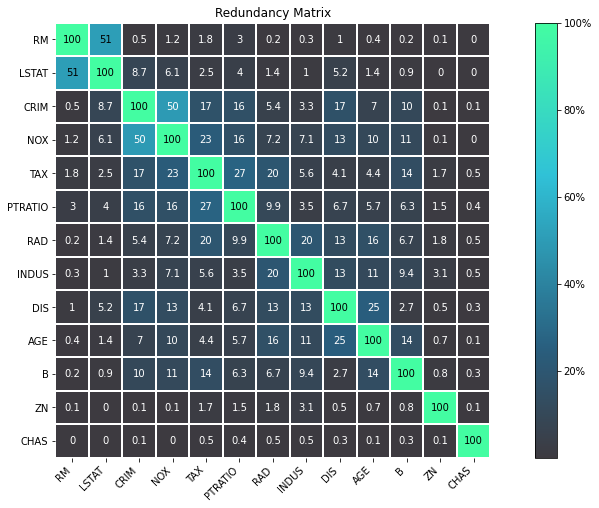

In [4]:
# fit the model inspector
from facet.inspection import LearnerInspector
inspector = LearnerInspector()
inspector.fit(crossfit=ranker.best_model_crossfit_)

# visualise redundancy as a matrix
from pytools.viz.matrix import MatrixDrawer
redundancy_matrix = inspector.feature_redundancy_matrix(symmetrical=True)
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Redundancy Matrix")

# save copy of plot to _static directory for documentation
plt.savefig(
    "facet/sphinx/source/_static/redundancy_matrix.png",
    bbox_inches="tight",
    pad_inches=0,
)

We can also better visualize redundancy as a dendrogram so we can identify clusters of features with redundancy.

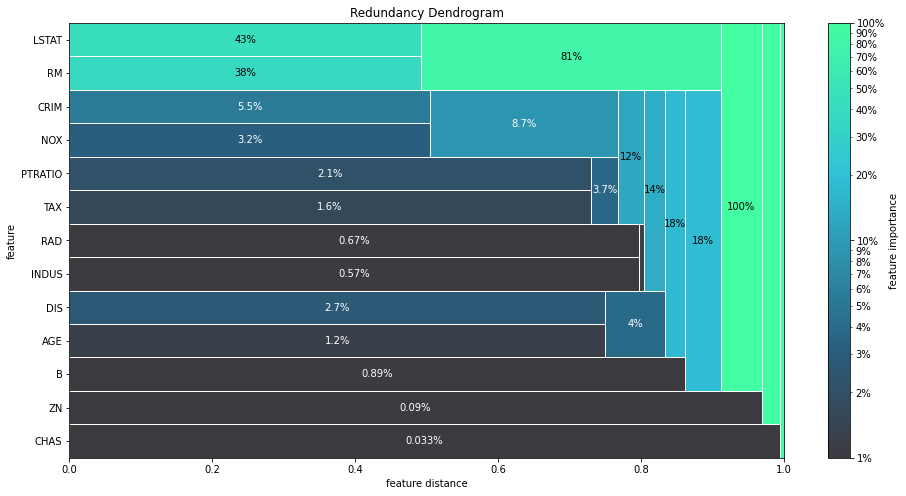

In [5]:
# visualise redundancy using a dendrogram
from pytools.viz.dendrogram import DendrogramDrawer
redundancy = inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(data=redundancy, title="Redundancy Dendrogram")

# save copy of plot to _static directories for documentation
plt.savefig(
    "facet/sphinx/source/_static/redundancy_dendrogram.png",
    bbox_inches="tight",
    pad_inches=0,
)

For feature synergy, we can get a similar picture.

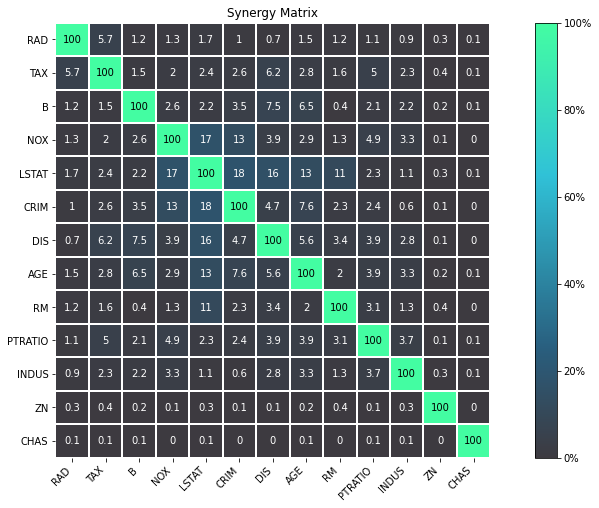

In [6]:
# visualise synergy as a matrix
synergy_matrix = inspector.feature_synergy_matrix(symmetrical=True)
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy Matrix")

# save copy of plot to _static directory for documentation
plt.savefig(
    "facet/sphinx/source/_static/synergy_matrix.png", bbox_inches="tight", pad_inches=0
)

Please see the API documentation for more detail.

# Simulation

Taking the LSTAT feature as an example, we do the following for the simulation: 

- We use FACET's `ContinuousRangePartitioner` to split the range of observed values of LSTAT into intervals of equal size. Each partition is represented by the central value of that partition. 
- For each partition, the simulator creates an artificial copy of the original sample assuming the variable to be simulated has the same value across all observations - which is the value representing the partition. Using the best `LearnerCrossfit` acquired from the ranker, the simulator now re-predicts all targets using the models trained for all folds and determines the average uplift of the target variable resulting from this.
- The FACET `SimulationDrawer` allows us to visualise the result; both in a matplotlib and a plain-text style.

Finally, because FACET can use bootstrap cross validation, we can create a crossfit from our previous `LearnerRanker` best model to perform the simulation so we can quantify the uncertainty by using bootstrap confidence intervals.

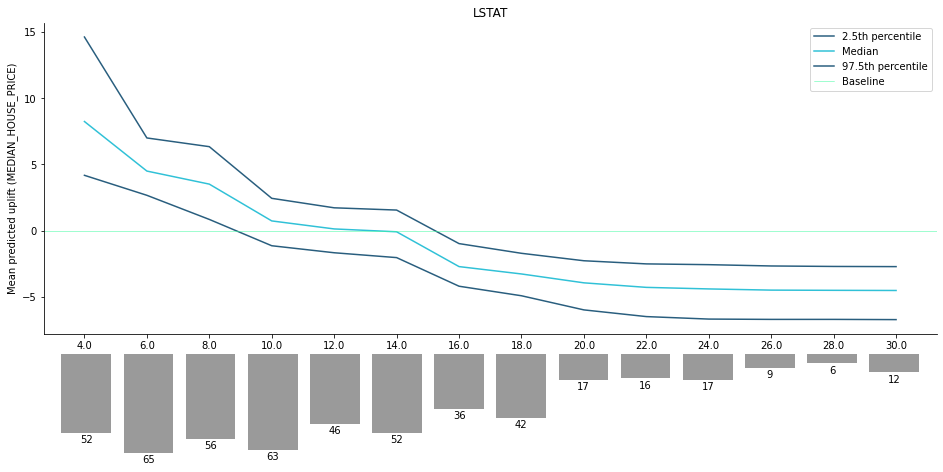

In [7]:
# FACET imports
from facet.validation import BootstrapCV
from facet.crossfit import LearnerCrossfit
from facet.simulation import UnivariateUpliftSimulator
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation.viz import SimulationDrawer

# create bootstrap CV iterator
bscv = BootstrapCV(n_splits=1000, random_state=42)

# create a bootstrap CV crossfit for simulation using best model
boot_crossfit = LearnerCrossfit(
    pipeline=ranker.best_model_,
    cv=bscv,
    n_jobs=-3,
    verbose=False,
).fit(sample=boston_sample)

SIM_FEAT = "LSTAT"
simulator = UnivariateUpliftSimulator(crossfit=boot_crossfit, n_jobs=-3)

# split the simulation range into equal sized partitions
partitioner = ContinuousRangePartitioner()

# run the simulation
simulation = simulator.simulate_feature(feature_name=SIM_FEAT, partitioner=partitioner)

# visualise results
SimulationDrawer().draw(data=simulation, title=SIM_FEAT)

# save copy of plot to _static directory for documentation
plt.savefig(
    "facet/sphinx/source/_static/simulation_output.png",
    bbox_inches="tight",
    pad_inches=0,
)